In [1]:
from fastai2.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=0.7)

In [6]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds, cl_type=TensorMask))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds, cl_type=TensorMask))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [8]:
loss_func = StackLoss(CrossEntropyLossFlat(axis=2))

Left: Input, Right: Target

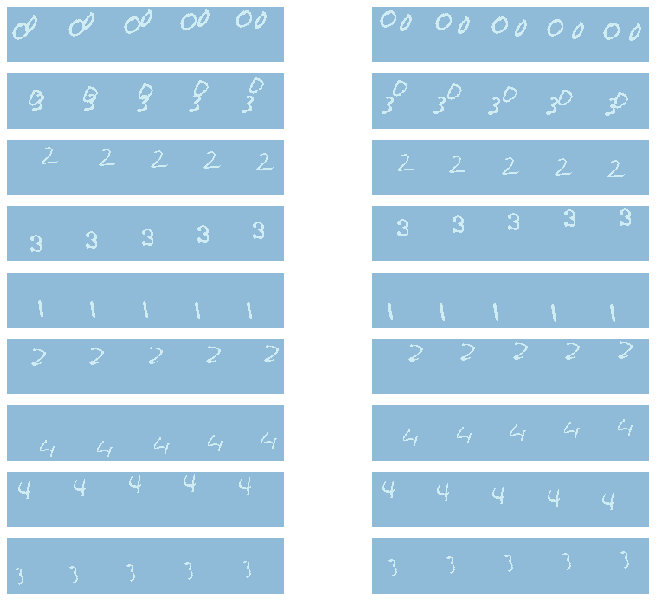

In [9]:
dls.show_batch()

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [22]:
model = StackUnstack(SimpleModel(n_in=1, n_out=2, act=partial(nn.LeakyReLU, 0.2, inplace=True)))

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [23]:
learn = Learner(dls, model, loss_func=loss_func, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

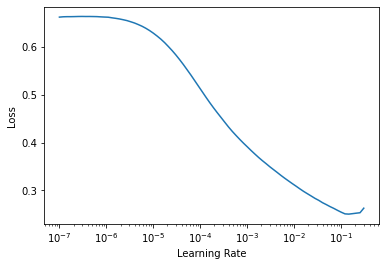

In [12]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.108536,0.079311,00:31
1,0.078216,0.070166,00:32
2,0.068149,0.060937,00:32
3,0.062515,0.061630,00:32
4,0.056794,0.056972,00:32
5,0.052309,0.047333,00:32
6,0.049340,0.047335,00:32
7,0.045684,0.041482,00:32
8,0.044063,0.046760,00:32
9,0.042603,0.046245,00:32


In [25]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [26]:
len(p), p[0].shape

(5, torch.Size([100, 2, 64, 64]))

In [27]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

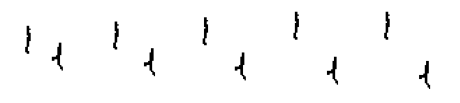

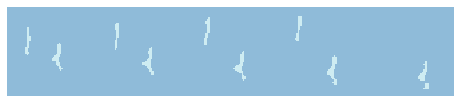

In [57]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, True)

## BN

In [61]:
model = StackUnstack(SimpleModel(n_in=1, n_out=2, act=partial(nn.LeakyReLU, 0.2, inplace=True), norm=NormType.Batch))

In [62]:
learn_zero = Learner(dls, model, loss_func=loss_func, cbs=[]).to_fp16()

In [63]:
learn_zero.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.348422,0.151068,00:33
1,0.106311,0.071839,00:33
2,0.071302,0.063577,00:33
3,0.062258,0.060213,00:33
4,0.056826,0.052302,00:34
5,0.052615,0.050987,00:34
6,0.049535,0.048707,00:34
7,0.046689,0.048567,00:34
8,0.043856,0.043590,00:34
9,0.042920,0.046832,00:34


In [61]:
p,t = learn_zero.get_preds()

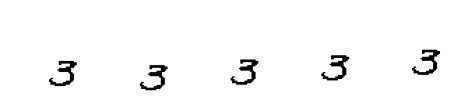

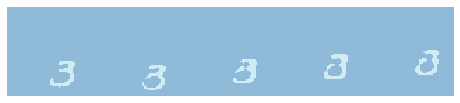

In [64]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k, True)

## A bigger Decoder

We will pass:
- `blur`: to use blur on the upsampling path (this is done by using and a poolling layer and a replication)
- `attn`: to include a self attention layer on the decoder

In [16]:
model_attn = StackUnstack(SimpleModel(n_in=1, n_out=2, act=partial(nn.LeakyReLU, 0.2, inplace=True),blur=True, attn=True))

We have to reduce batch size as the self attention layer is heavy.

In [17]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=32,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [18]:
learn2 = Learner(dls, model_attn, loss_func=loss_func, cbs=[]).to_fp16()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

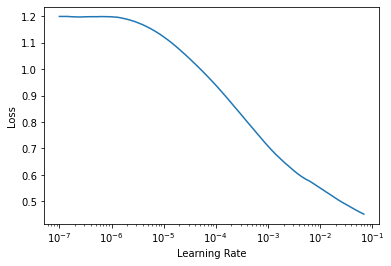

In [14]:
learn2.lr_find()

In [19]:
learn2.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.083753,0.073382,02:10
1,0.068490,0.064541,02:12
2,0.060579,0.060085,02:12
3,0.054132,0.052336,02:12
4,0.050860,0.050257,02:12
5,0.047723,0.049679,02:12
6,0.044328,0.045465,02:12
7,0.042036,0.041564,02:12
8,0.040124,0.041111,02:12
9,0.039094,0.039972,02:12


In [20]:
p,t = learn2.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [21]:
len(p), p[0].shape

(5, torch.Size([100, 2, 64, 64]))

In [24]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

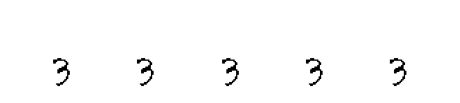

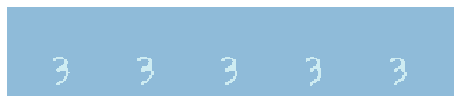

In [31]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, True)